# Install and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/Credit Card Fraud Analysis'

/content/drive/MyDrive/Credit Card Fraud Analysis


In [3]:
!pip install pyspark pretty-errors

In [4]:
from pyspark.sql import SparkSession
import os, sys, matplotlib.pyplot as plt, seaborn as sns, pretty_errors

In [5]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [6]:
from sklearn.metrics import classification_report

In [7]:
from config import PROJECT_PATH

In [8]:
sys.path.append(os.path.join(PROJECT_PATH, 'Source'))

In [9]:
from data_processing import *
from data_visualization import *
from metrics_visualization import *

In [10]:
from pyspark.sql import functions as F
import pandas as pd, numpy as np

# Config

In [16]:
train_dir = os.path.join(PROJECT_PATH, 'Datasets/finalTrain.csv')
test_dir = os.path.join(PROJECT_PATH, 'Datasets/finalTest.csv')

In [17]:
sc = SparkSession.builder \
    .appName("fraudDetection") \
    .config("spark.driver.maxResultSize", "3g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()
train = sc.read.csv(train_dir, inferSchema = True, header = True)
test = sc.read.csv(test_dir, inferSchema = True, header = True)

In [18]:
train, test = train.drop('_c0'), test.drop('_c0')
train.show()

+------+----+----------+-----+--------+-------------+
|   amt| age|trans_hour|state|is_fraud|     category|
+------+----+----------+-----+--------+-------------+
|  4.97|36.0|         0|   NC|       0|     misc_net|
|107.23|46.0|         0|   WA|       0|  grocery_pos|
|220.11|62.0|         0|   ID|       0|entertainment|
|  45.0|57.0|         0|   MT|       0|gas_transport|
| 41.96|38.0|         0|   VA|       0|     misc_pos|
| 94.63|63.0|         0|   PA|       0|gas_transport|
| 44.54|31.0|         0|   KS|       0|  grocery_net|
| 71.65|77.0|         0|   VA|       0|gas_transport|
|  4.27|83.0|         0|   PA|       0|     misc_pos|
|198.39|50.0|         0|   TN|       0|  grocery_pos|
| 24.74|34.0|         0|   IA|       0|  grocery_pos|
|  7.77|58.0|         0|   WV|       0| shopping_net|
| 71.22|35.0|         0|   FL|       0|  grocery_pos|
| 96.29|79.0|         0|   CA|       0|  grocery_pos|
|  7.77|57.0|         0|   NM|       0| shopping_pos|
|  3.26|59.0|         0|   N

In [19]:
print(f'Train shape: {train.count()} rows, {len(train.columns)} columns')
print(f'Test shape: {test.count()} rows, {len(test.columns)} columns')

Train shape: 1296675 rows, 6 columns
Test shape: 555719 rows, 6 columns


In [27]:
string_indexer = StringIndexer(inputCols = ['state', 'category'], outputCols = ['state_idx', 'category_idx'])
encoder = OneHotEncoder(inputCols = ['state_idx', 'category_idx'], outputCols = ['state_vec', 'category_vec'])
log_transformer = LogTransformer(input_col = 'amt', output_col = 'log_amt')
assembler = VectorAssembler(inputCols = ['state_vec', 'category_vec', 'log_amt', 'trans_hour', 'age'], outputCol = 'features')
dct = DecisionTreeClassifier(labelCol = 'is_fraud', featuresCol = 'features')

# Imbalanced data

In [19]:
train_test_show(train, test, figsize = (12, 4))

NameError: name 'train_test_show' is not defined

100%|██████████| 3/3 [00:00<00:00,  7.33it/s]


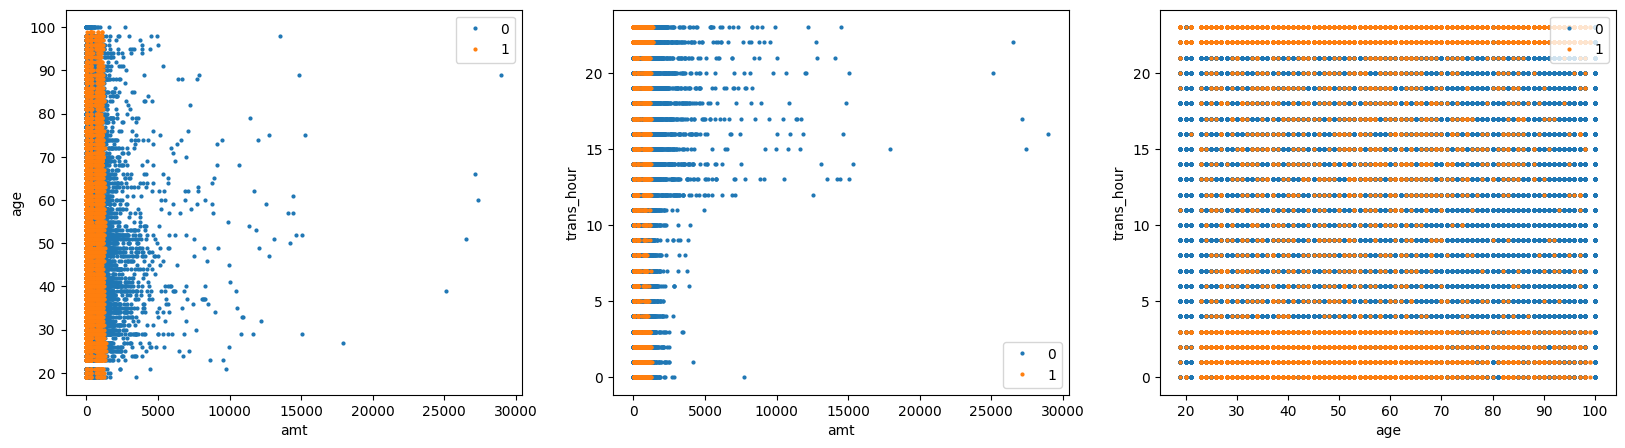

In [16]:
scatter_plots(train.toPandas(), x = [ 'amt', 'age', 'trans_hour'], y = 'is_fraud', figsize = (20, 5), shape = (1, 3))

In [ ]:
pipeline = Pipeline(stages = [string_indexer, encoder, log_transformer, assembler, dct])

In [ ]:
pipeline_model = pipeline.fit(train)
train_preds, test_preds = pipeline_model.transform(train), pipeline_model.transform(test)

In [ ]:
test_scores = test_preds.select('is_fraud', 'prediction', 'probability').toPandas()
class_report = classification_report(y_true = test_scores['is_fraud'], y_pred = test_scores['prediction'])
print(f'Classification report for imbalanced data: \n {class_report}')

Classification report for imbalanced data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.73      0.54      0.62      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.77      0.81    555719
weighted avg       1.00      1.00      1.00    555719



In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'probability', labelCol = 'is_fraud', metricName = 'areaUnderROC')
roc = evaluator.evaluate(test_preds)

print(f"Area under ROC curve: {roc:.4f}")

Area under ROC curve: 0.9547


In [ ]:
labels_and_preds = test_preds.select(F.col('prediction').cast('double'), F.col('is_fraud').cast('double')) \
                              .rdd \
                              .map(lambda row: (row['prediction'], row['is_fraud']))
metrics = MulticlassMetrics(labels_and_preds)

Confusion Matrix for imbalanced data:


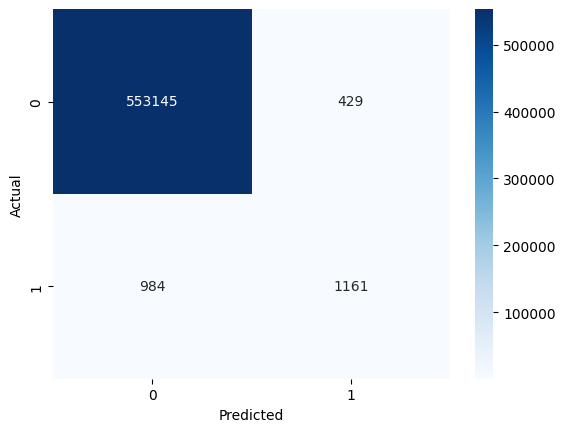

In [ ]:
print('Confusion Matrix for imbalanced data:')
heatmap(metrics.confusionMatrix().toArray())

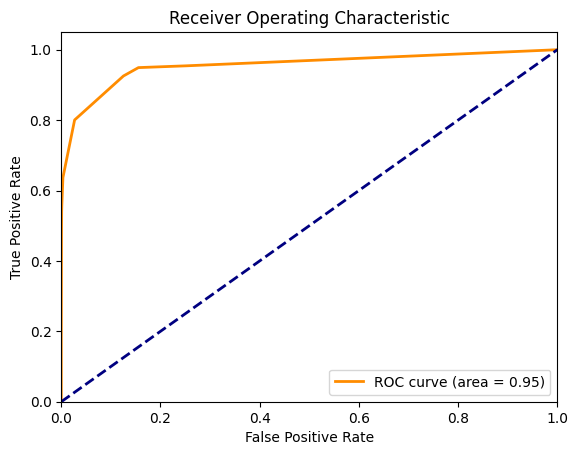

In [ ]:
proba = test_scores['probability'].apply(lambda x: x[1])
roc_auc_curve(test_scores['is_fraud'], proba)

In [ ]:
pipeline_model.stages

[StringIndexerModel: uid=StringIndexer_cec1848cf97c, handleInvalid=error, numInputCols=2, numOutputCols=2,
 OneHotEncoderModel: uid=OneHotEncoder_ffe2b1c1c6ba, dropLast=true, handleInvalid=error, numInputCols=2, numOutputCols=2,
 LogTransformer_1b1915b06598,
 VectorAssembler_33177b598a14,
 DecisionTreeClassificationModel: uid=DecisionTreeClassifier_aae83f85cccf, depth=5, numNodes=25, numClasses=2, numFeatures=66]

In [ ]:
dct_model, assembler, indexer_model = pipeline_model.stages[-1], pipeline_model.stages[-2], pipeline_model.stages[0]
feature_importances = dct_model.featureImportances.toArray()
input_cols = assembler.getInputCols()
variables_labels = indexer_model.labelsArray

# Under-Sampling

In [ ]:
minority_class, majority_class = train.where(F.col('is_fraud') == 1), train.where(F.col('is_fraud') == 0)
fraction = minority_class.count() / train.count()
fraction

0.005788651743883394

In [ ]:
resampled_majority_class = majority_class.sample(withReplacement = False, fraction = fraction)
resampled_train = minority_class.union(resampled_majority_class)
resampled_train.groupby('is_fraud').count().show()

+--------+-----+
|is_fraud|count|
+--------+-----+
|       1| 7506|
|       0| 7494|
+--------+-----+



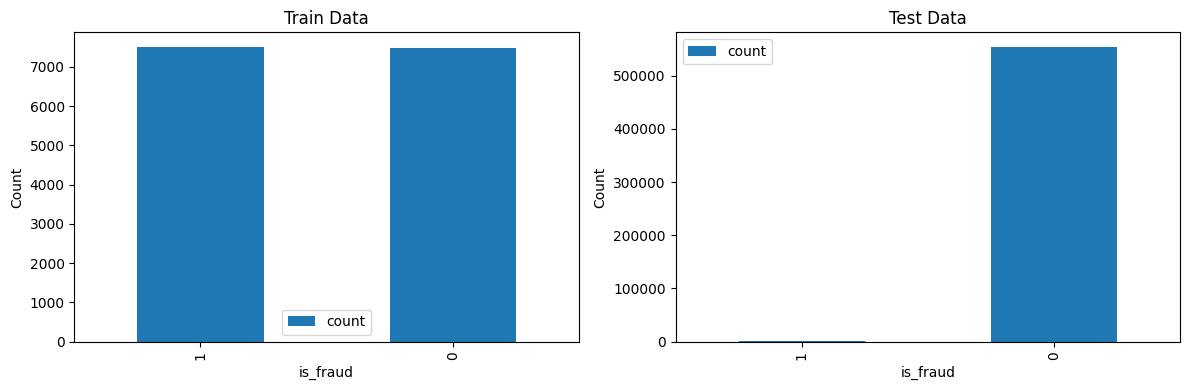

In [ ]:
train_test_show(resampled_train, test, figsize = (12, 4))

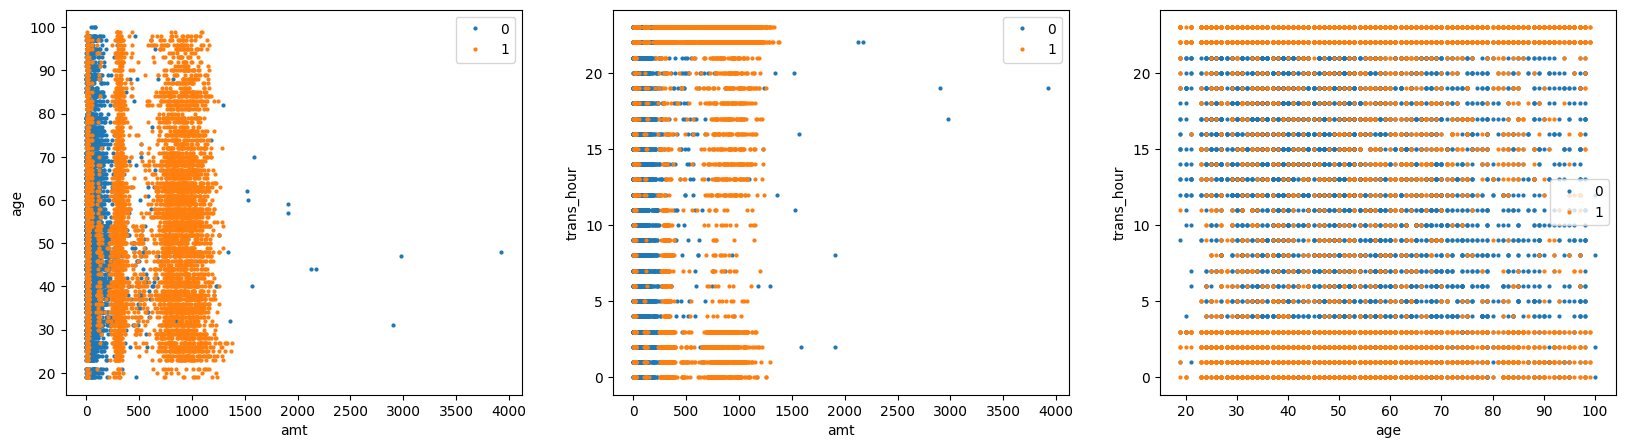

In [ ]:
scatter_plots(resampled_train.toPandas(), x = [ 'amt', 'age', 'trans_hour'], y = 'is_fraud', figsize = (20, 5), shape = (1, 3))

In [ ]:
pipeline = Pipeline(stages = [string_indexer, encoder, log_transformer, assembler, dct])
pipeline_model = pipeline.fit(resampled_train)
train_preds, test_preds = pipeline_model.transform(resampled_train), pipeline_model.transform(test)

In [ ]:
test_scores = test_preds.select('is_fraud', 'prediction', 'probability').toPandas()
class_report = classification_report(y_true = test_scores['is_fraud'], y_pred = test_scores['prediction'])
print(f'Classification report for under-sampled data: \n {class_report}')

Classification report for under-sampled data: 
               precision    recall  f1-score   support

           0       1.00      0.95      0.98    553574
           1       0.07      0.93      0.14      2145

    accuracy                           0.95    555719
   macro avg       0.54      0.94      0.56    555719
weighted avg       1.00      0.95      0.97    555719



In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'probability', labelCol = 'is_fraud', metricName = 'areaUnderROC')
roc = evaluator.evaluate(test_preds)

print(f"Area under ROC curve: {roc:.4f}")

Area under ROC curve: 0.9751


In [ ]:
labels_and_preds = test_preds.select(F.col('prediction').cast('double'), F.col('is_fraud').cast('double')) \
                              .rdd \
                              .map(lambda row: (row['prediction'], row['is_fraud']))
metrics = MulticlassMetrics(labels_and_preds)

Confusion Matrix for under-sampled data:


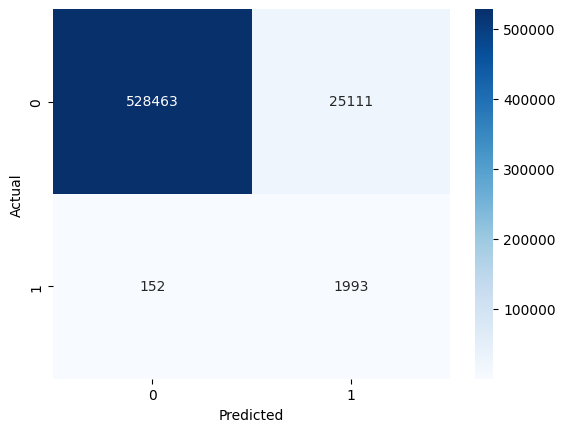

In [ ]:
print('Confusion Matrix for under-sampled data:')
heatmap(metrics.confusionMatrix().toArray())

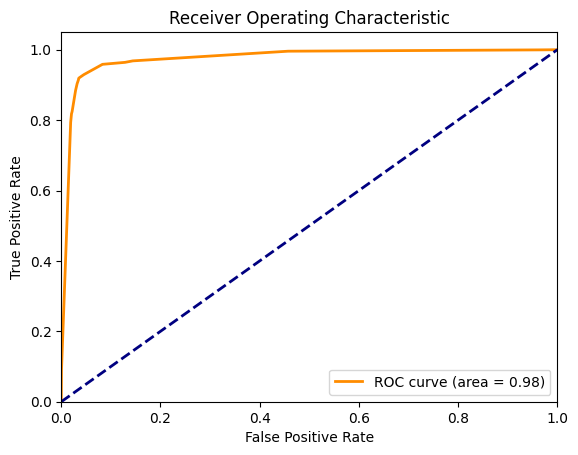

In [ ]:
proba = test_scores['probability'].apply(lambda x: x[1])
roc_auc_curve(test_scores['is_fraud'], proba)

In [ ]:
dct_model, assembler = pipeline_model.stages[-1], pipeline_model.stages[-2]
feature_importances = dct_model.featureImportances.toArray()

In [ ]:
input_cols = assembler.getInputCols()
state_indexer_model = pipeline_model.stages[0]
state_labels = state_indexer_model.labels
feature_names = [state for i, state in enumerate(state_labels)] + input_cols[1:]
feature_importance(feature_importances, feature_names, figsize = (15, 10))

# Over-sampling

In [ ]:
ratio = majority_class.count() // minority_class.count()
a = range(ratio)
oversampled_minority = minority_class.withColumn("dummy", F.explode(F.array([F.lit(x) for x in a]))).drop('dummy')

oversampled_train = majority_class.unionAll(oversampled_minority)
oversampled_train.show()

+------+----+----------+-----+--------+-------------+
|   amt| age|trans_hour|state|is_fraud|     category|
+------+----+----------+-----+--------+-------------+
|  4.97|36.0|         0|   NC|       0|     misc_net|
|107.23|46.0|         0|   WA|       0|  grocery_pos|
|220.11|62.0|         0|   ID|       0|entertainment|
|  45.0|57.0|         0|   MT|       0|gas_transport|
| 41.96|38.0|         0|   VA|       0|     misc_pos|
| 94.63|63.0|         0|   PA|       0|gas_transport|
| 44.54|31.0|         0|   KS|       0|  grocery_net|
| 71.65|77.0|         0|   VA|       0|gas_transport|
|  4.27|83.0|         0|   PA|       0|     misc_pos|
|198.39|50.0|         0|   TN|       0|  grocery_pos|
| 24.74|34.0|         0|   IA|       0|  grocery_pos|
|  7.77|58.0|         0|   WV|       0| shopping_net|
| 71.22|35.0|         0|   FL|       0|  grocery_pos|
| 96.29|79.0|         0|   CA|       0|  grocery_pos|
|  7.77|57.0|         0|   NM|       0| shopping_pos|
|  3.26|59.0|         0|   N

In [ ]:
duplicate_counts = oversampled_train.groupBy(oversampled_train.columns).count().filter(F.col('count') > 1).count()
print(f'Number of duplicate rows: {duplicate_counts}')

Number of duplicate rows: 10124


In [ ]:
oversampled_train.groupby('is_fraud').count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       0|1289169|
|       1|1283526|
+--------+-------+



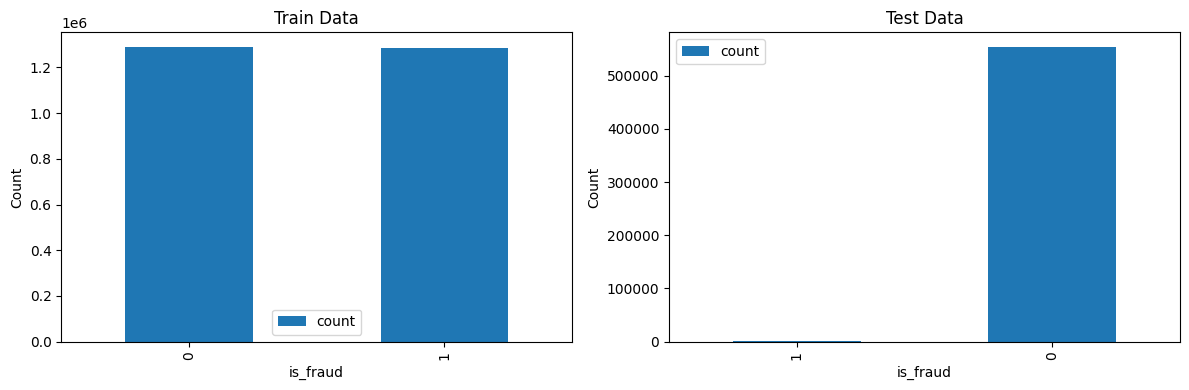

In [ ]:
train_test_show(oversampled_train, test, figsize = (12, 4))

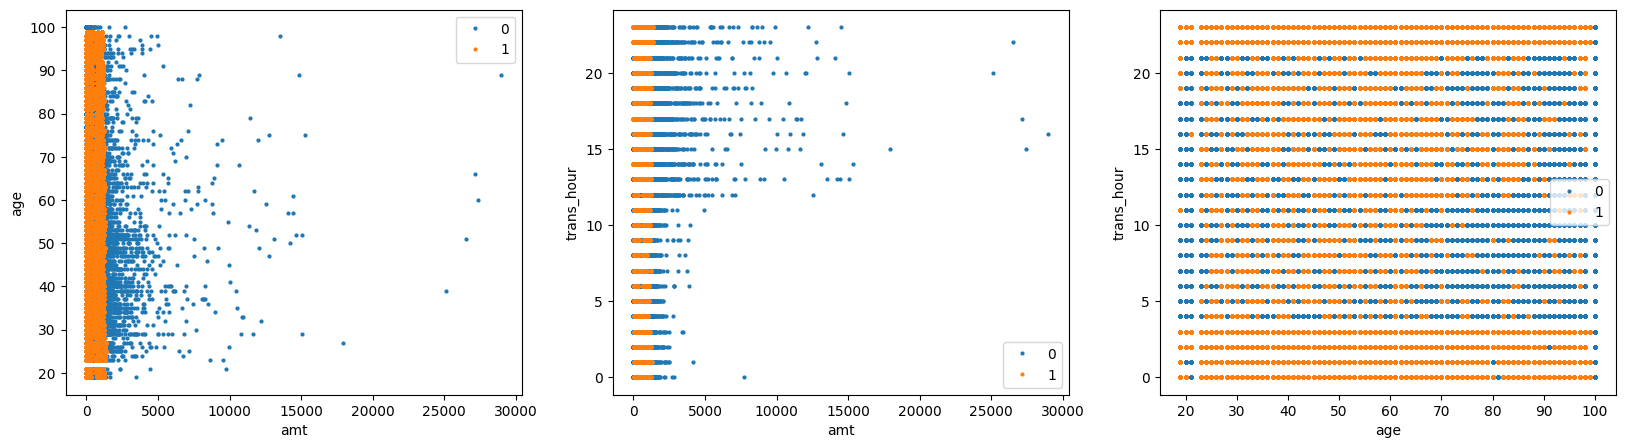

In [ ]:
scatter_plots(oversampled_train.toPandas(), x = [ 'amt', 'age', 'trans_hour'], y = 'is_fraud', figsize = (20, 5), shape = (1, 3))

In [ ]:
pipeline = Pipeline(stages = [string_indexer, encoder, log_transformer, assembler, dct])
pipeline_model = pipeline.fit(oversampled_train)
train_preds, test_preds = pipeline_model.transform(oversampled_train), pipeline_model.transform(test)

In [ ]:
test_scores = test_preds.select('is_fraud', 'prediction', 'probability').toPandas()
class_report = classification_report(test_scores['is_fraud'], test_scores['prediction'])
print(f'Classification report for over-sampled data: \n {class_report}')

Classification report for over-sampled data: 
               precision    recall  f1-score   support

           0       1.00      0.95      0.98    553574
           1       0.07      0.89      0.12      2145

    accuracy                           0.95    555719
   macro avg       0.53      0.92      0.55    555719
weighted avg       1.00      0.95      0.97    555719



In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'probability', labelCol = 'is_fraud', metricName = 'areaUnderROC')
roc = evaluator.evaluate(test_preds)

print(f"Area under ROC curve: {roc:.4f}")

Area under ROC curve: 0.9651


In [ ]:
labels_and_preds = test_preds.select(F.col('prediction').cast('double'), F.col('is_fraud').cast('double')) \
                              .rdd \
                              .map(lambda row: (row['prediction'], row['is_fraud']))
metrics = MulticlassMetrics(labels_and_preds)

Confusion Matrix for over-sampled data:


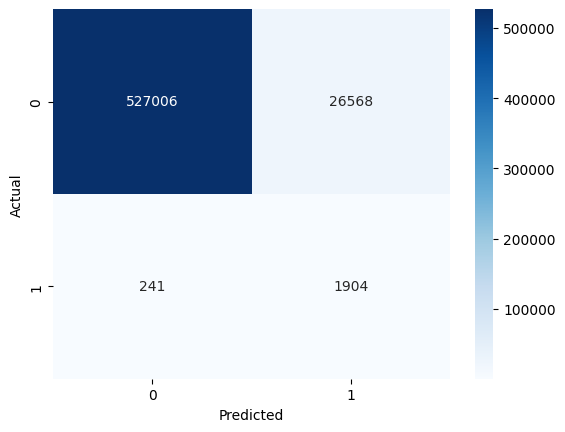

In [ ]:
print('Confusion Matrix for over-sampled data:')
heatmap(metrics.confusionMatrix().toArray())

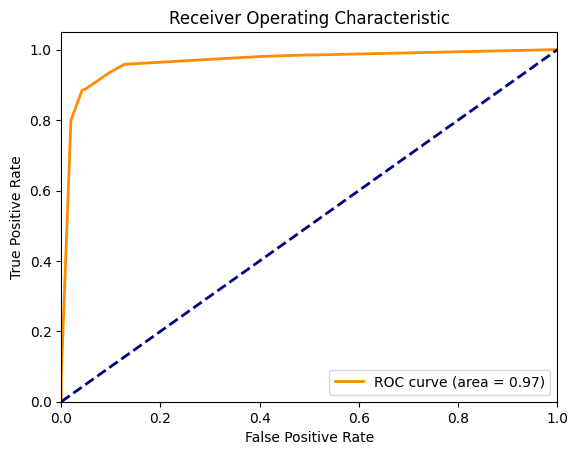

In [ ]:
proba = test_scores['probability'].apply(lambda x: x[1])
roc_auc_curve(test_scores['is_fraud'], proba)

In [ ]:
dct_model, assembler = pipeline_model.stages[-1], pipeline_model.stages[-2]
feature_importances = dct_model.featureImportances.toArray()

In [ ]:
input_cols = assembler.getInputCols()
state_indexer_model = pipeline_model.stages[0]
state_labels = state_indexer_model.labels
feature_names = [state for i, state in enumerate(state_labels)] + input_cols[1:]
feature_importance(feature_importances, feature_names, figsize = (15, 10))

# SMOTE

In [21]:
from imblearn.over_sampling import SMOTENC

In [22]:
train_smote = train.toPandas()

In [23]:
features = ['amt', 'age', 'trans_hour', 'category', 'state']
train_smote = train_smote[features + ['is_fraud']]
train_smote.head()

,amt,age,trans_hour,category,state,is_fraud
0,4.97,36.0,0,misc_net,NC,0
1,107.23,46.0,0,grocery_pos,WA,0
2,220.11,62.0,0,entertainment,ID,0
3,45.00,57.0,0,gas_transport,MT,0
4,41.96,38.0,0,misc_pos,VA,0


In [24]:
smote = SMOTENC(random_state = 42, categorical_features = [features.index('category'), features.index('state')], sampling_strategy = 'minority')
X_resampled, y_resampled = smote.fit_resample(train_smote[features], train_smote['is_fraud'])

In [22]:
new_train = pd.concat([X_resampled, y_resampled], axis = 1)
new_train.columns = features + ['is_fraud']
new_train.head()

,amt,age,trans_hour,category,state,is_fraud
0,4.97,36.0,0,misc_net,NC,0
1,107.23,46.0,0,grocery_pos,WA,0
2,220.11,62.0,0,entertainment,ID,0
3,45.00,57.0,0,gas_transport,MT,0
4,41.96,38.0,0,misc_pos,VA,0


In [23]:
new_train = sc.createDataFrame(new_train)
new_train.show()

+------+----+----------+-------------+-----+--------+
|   amt| age|trans_hour|     category|state|is_fraud|
+------+----+----------+-------------+-----+--------+
|  4.97|36.0|         0|     misc_net|   NC|       0|
|107.23|46.0|         0|  grocery_pos|   WA|       0|
|220.11|62.0|         0|entertainment|   ID|       0|
|  45.0|57.0|         0|gas_transport|   MT|       0|
| 41.96|38.0|         0|     misc_pos|   VA|       0|
| 94.63|63.0|         0|gas_transport|   PA|       0|
| 44.54|31.0|         0|  grocery_net|   KS|       0|
| 71.65|77.0|         0|gas_transport|   VA|       0|
|  4.27|83.0|         0|     misc_pos|   PA|       0|
|198.39|50.0|         0|  grocery_pos|   TN|       0|
| 24.74|34.0|         0|  grocery_pos|   IA|       0|
|  7.77|58.0|         0| shopping_net|   WV|       0|
| 71.22|35.0|         0|  grocery_pos|   FL|       0|
| 96.29|79.0|         0|  grocery_pos|   CA|       0|
|  7.77|57.0|         0| shopping_pos|   NM|       0|
|  3.26|59.0|         0| sho

In [28]:
train.select('is_fraud').groupby('is_fraud').count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|   7506|
|       0|1289169|
+--------+-------+



In [27]:
new_train.select('is_fraud').groupby('is_fraud').count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       0|1289169|
|       1|1289169|
+--------+-------+



100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


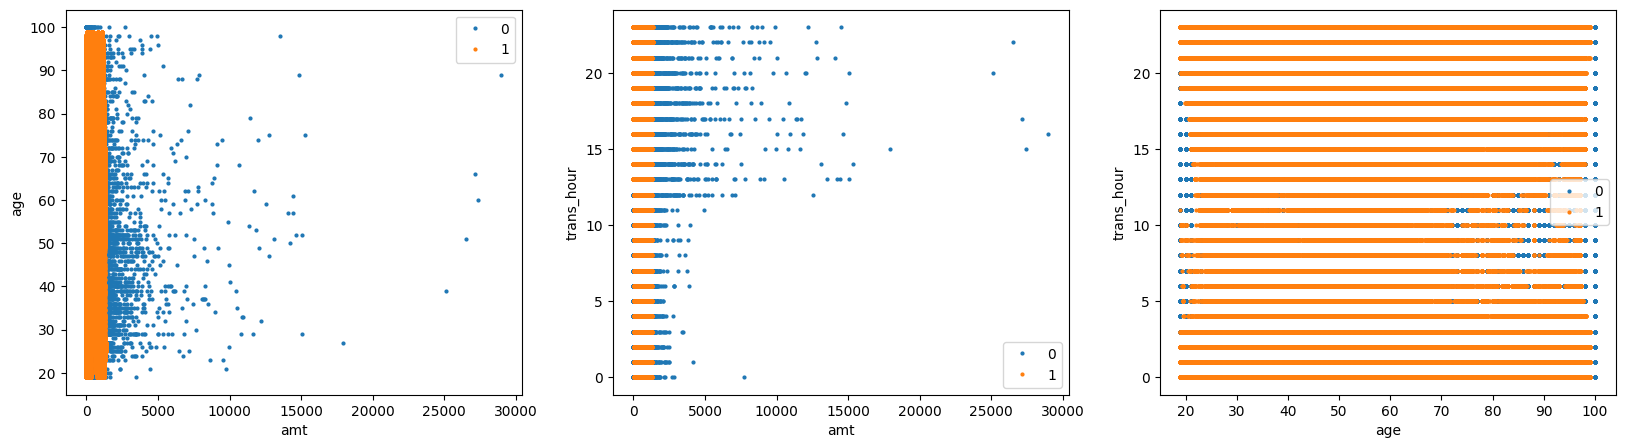

In [29]:
scatter_plots(new_train.toPandas(), x = [ 'amt', 'age', 'trans_hour'], y = 'is_fraud', figsize = (20, 5), shape = (1, 3))

In [31]:
pipeline = Pipeline(stages = [indexer ,encoder, log_transformer, assembler, dct])
pipeline_model = pipeline.fit(new_train)
train_preds, test_preds = pipeline_model.transform(new_train), pipeline_model.transform(test)

In [32]:
test_scores = test_preds.select('is_fraud', 'prediction', 'probability').toPandas()
class_report = classification_report(test_scores['is_fraud'], test_scores['prediction'])
print(f'Classification report for over-sampled data: \n {class_report}')

Classification report for over-sampled data: 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    553574
           1       0.06      0.92      0.11      2145

    accuracy                           0.94    555719
   macro avg       0.53      0.93      0.54    555719
weighted avg       1.00      0.94      0.97    555719



## SMOTE tunning

In [28]:
from itertools import product
from tqdm import tqdm

parameters = [list(range(5, 11)), ['minority', 'all', 'auto']]
combinations = list(product(*parameters))

for combination in tqdm(combinations, desc = "Processing SMOTE parameters"):
  # SMOTE parameters
  smote = SMOTENC(random_state = 42, categorical_features = [features.index('category'), features.index('state')],
                  sampling_strategy = combination[1], k_neighbors = combination[0])
  X_resampled, y_resampled = smote.fit_resample(train_smote[features], train_smote['is_fraud'])
  new_train = sc.createDataFrame(pd.DataFrame(pd.concat([X_resampled, y_resampled], axis = 1), columns = features + ['is_fraud']))


  # Pipeline
  pipeline = Pipeline(stages = [string_indexer ,encoder, log_transformer, assembler, dct])
  pipeline_model = pipeline.fit(new_train)
  train_preds, test_preds = pipeline_model.transform(new_train), pipeline_model.transform(test)

  test_scores = test_preds.select('is_fraud', 'prediction', 'probability').toPandas()
  class_report = classification_report(test_scores['is_fraud'], test_scores['prediction'])
  print(f'Classification report for SMOTE data: {combination} \n {class_report}')


Processing SMOTE parameters:   0%|          | 0/18 [00:00<?, ?it/s]

Classification report for SMOTE data: (5, 'minority') 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    553574
           1       0.06      0.92      0.11      2145

    accuracy                           0.94    555719
   macro avg       0.53      0.93      0.54    555719
weighted avg       1.00      0.94      0.97    555719



Processing SMOTE parameters:   6%|▌         | 1/18 [05:45<1:37:51, 345.36s/it]

Classification report for SMOTE data: (5, 'all') 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    553574
           1       0.06      0.92      0.11      2145

    accuracy                           0.94    555719
   macro avg       0.53      0.93      0.54    555719
weighted avg       1.00      0.94      0.97    555719



Processing SMOTE parameters:  11%|█         | 2/18 [11:02<1:27:38, 328.63s/it]

Classification report for SMOTE data: (5, 'auto') 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    553574
           1       0.06      0.92      0.11      2145

    accuracy                           0.94    555719
   macro avg       0.53      0.93      0.54    555719
weighted avg       1.00      0.94      0.97    555719



Processing SMOTE parameters:  17%|█▋        | 3/18 [16:17<1:20:35, 322.34s/it]----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 58118)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/lib/python3.10/dist-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/usr/local/lib/python3.10/dist-packages/py

Py4JError: SparkSession does not exist in the JVM